# KoBART Basline Train - 4K
- GKSL 4K
- 모듈에서 불러오는 모델 아니고 huggingface에서 불러와서 적용
- 일반적 tokenizer말고 BART에 최적화된 토크나이저 불러옴

https://huggingface.co/hyunwoongko/kobart

## 0. 라이브러리 및 데이터 불러오기

In [1]:
!pip install sacrebleu

In [2]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim

#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device('cpu')

In [4]:
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

tokenizer = PreTrainedTokenizerFast.from_pretrained('hyunwoongko/kobart')
model = BartForConditionalGeneration.from_pretrained("hyunwoongko/kobart").to(device)

/home/stonemaeng/anaconda3/envs/g2t/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [5]:
model.config

BartConfig {
  "_name_or_path": "hyunwoongko/kobart",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 1,
  "extra_pos_embeddings": 2,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "kobart_ve

In [6]:
model.generate()

/home/stonemaeng/anaconda3/envs/g2t/lib/python3.12/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[    1, 15309, 15309, 15309, 15309, 15309, 15309, 15309, 15309, 15309,
         15309, 15309, 15309, 15309, 15309, 15309, 15309, 15309, 15309,     1]],
       device='cuda:0')

In [7]:
model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), 

### 데이터 불러오기

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/AIRC-KETI/GKSL-dataset/main/dataset/GKSL13k_augmented.csv')
df.columns = ['augmentation_method', 'idx', 'gloss', 'text']
df.head(30)

,augmentation_method,idx,gloss,text
0,SR,1,집 불,댁에 불이 났어요.
1,SR,2,집 불,주택에 불이 났어요.
2,SR,3,집 불,가옥에 불이 났어요.
3,SR,4,집 불,세대에 불이 났어요.
4,SR,5,도착 10분 전,10분 내로 당도합니다.
5,SR,6,도착 10분,10분 뒤에 당도합니다.
6,SR,7,도착 1시간 전,1시간 내로 당도합니다.
7,SR,8,도착 1시,1시에 당도합니다.
8,SR,9,1호 갈아타다 목적 곳곳,1호선 환승하는 위치는 어디인가요?
9,SR,10,1호 갈아타다 목적 곳곳,1호선 환승하는 장소는 어디인가요?


## 1. 데이터 파악

In [9]:
len(df), len(df.gloss.unique()), len(df.text.unique())

(13047, 11345, 8451)

In [10]:
for i in df.augmentation_method.unique():
  print(i, ':', len(df[df.augmentation_method==i]))

SR : 899
SP : 1494
BR : 10654


In [11]:
# '?'가 포함된 행 제거
print(len(df[~df['text'].str.contains('\?')])/len(df)) # 절반 이상 날라감
df[~df['text'].str.contains('\?')].head(10)

0.6439028129071818


<>:2: SyntaxWarning: invalid escape sequence '\?'
<>:3: SyntaxWarning: invalid escape sequence '\?'
<>:2: SyntaxWarning: invalid escape sequence '\?'
<>:3: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipykernel_8395/1118718847.py:2: SyntaxWarning: invalid escape sequence '\?'
  print(len(df[~df['text'].str.contains('\?')])/len(df)) # 절반 이상 날라감
/tmp/ipykernel_8395/1118718847.py:3: SyntaxWarning: invalid escape sequence '\?'
  df[~df['text'].str.contains('\?')].head(10)


,augmentation_method,idx,gloss,text
0,SR,1,집 불,댁에 불이 났어요.
1,SR,2,집 불,주택에 불이 났어요.
2,SR,3,집 불,가옥에 불이 났어요.
3,SR,4,집 불,세대에 불이 났어요.
4,SR,5,도착 10분 전,10분 내로 당도합니다.
5,SR,6,도착 10분,10분 뒤에 당도합니다.
6,SR,7,도착 1시간 전,1시간 내로 당도합니다.
7,SR,8,도착 1시,1시에 당도합니다.
12,SR,13,2016 새롭다 날 시작,"2016년, 새해가 출발한다"
13,SR,14,도착 3시,3시에 당도합니다.


### 데이터 전처리

In [12]:
df = df[~df['text'].str.contains('\?')]
df = df[['gloss', 'text']]
df.head(30)

<>:1: SyntaxWarning: invalid escape sequence '\?'
<>:1: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipykernel_8395/123297376.py:1: SyntaxWarning: invalid escape sequence '\?'
  df = df[~df['text'].str.contains('\?')]


,gloss,text
0,집 불,댁에 불이 났어요.
1,집 불,주택에 불이 났어요.
2,집 불,가옥에 불이 났어요.
3,집 불,세대에 불이 났어요.
4,도착 10분 전,10분 내로 당도합니다.
5,도착 10분,10분 뒤에 당도합니다.
6,도착 1시간 전,1시간 내로 당도합니다.
7,도착 1시,1시에 당도합니다.
12,2016 새롭다 날 시작,"2016년, 새해가 출발한다"
13,도착 3시,3시에 당도합니다.


### 문장 길이 시각화
max_len 설정을 위함

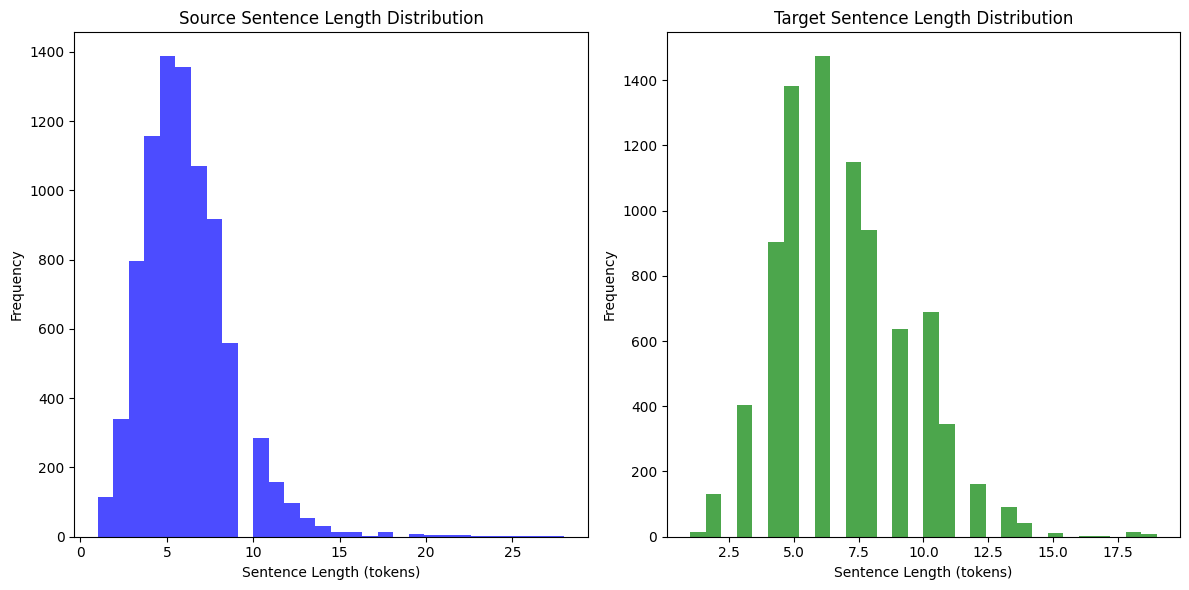

In [13]:
import matplotlib.pyplot as plt

# 각 문장의 토큰 길이를 KoBART 토크나이저로 계산 -> 서브워드 단어로 더 잘게 쪼개줌
df['source_len'] = df['gloss'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
df['target_len'] = df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))

# 히스토그램을 그려서 분포 확인
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['source_len'], bins=30, color='blue', alpha=0.7)
plt.title('Source Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['target_len'], bins=30, color='green', alpha=0.7)
plt.title('Target Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [14]:
# 문장 길이 통계
source_stats = df['source_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])
target_stats = df['target_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])

print("Source Sentence Length Stats:\n", source_stats)
print("\nTarget Sentence Length Stats:\n", target_stats)

Source Sentence Length Stats:
 count    8401.000000
mean        6.081776
std         2.704424
min         1.000000
25%         4.000000
50%         6.000000
75%         8.000000
90%         9.000000
95%        10.000000
99%        14.000000
max        28.000000
Name: source_len, dtype: float64

Target Sentence Length Stats:
 count    8401.000000
mean        6.805618
std         2.523546
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
90%        10.000000
95%        11.000000
99%        13.000000
max        19.000000
Name: target_len, dtype: float64


## 2. 데이터 로더 생성

In [15]:
class GlossDataset(Dataset):
    def __init__(self, glosses, texts, tokenizer, max_len=10):
        self.glosses = glosses
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    # 데이터셋의 크기를 반환
    def __len__(self):
        return len(self.glosses)

    def __getitem__(self, idx):
        # 데이터 로드 및 전처리
        gloss = str(self.glosses[idx])
        text = str(self.texts[idx])

        # 토큰화
        inputs = self.tokenizer(
            gloss,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt" # 토큰화된 결과를 PyTorch 텐서로 반환
        )

        outputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # 텐서 데이터 처리
        input_ids = inputs.input_ids.squeeze() # 1차원 처리해 gloss 토큰 id 텐서
        attention_mask = inputs.attention_mask.squeeze() # 마스킹 처리
        labels = outputs.input_ids.squeeze() # 1차원 처리해 text 토큰 id 텐서
        labels[labels == tokenizer.pad_token_id] = -100  # labels 텐서에서 패딩 토큰의 ID를 -100 변경 -> 학습 시 영향 안줌

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        } # 모델 학습에 사용될 데이터 로더에 의해 처리

In [16]:
from sklearn.model_selection import train_test_split

# 데이터셋 분할
train_glosses, val_glosses, train_texts, val_texts = train_test_split(df['gloss'].tolist(), df['text'].tolist(), test_size=0.2, random_state=42)
val_glosses, test_glosses, val_texts, test_texts = train_test_split(val_glosses, val_texts, test_size=0.5, random_state=42)

# 데이터셋 생성
train_dataset = GlossDataset(glosses=train_glosses, texts=train_texts, tokenizer=tokenizer)
val_dataset = GlossDataset(glosses=val_glosses, texts=val_texts, tokenizer=tokenizer)
test_dataset = GlossDataset(glosses=test_glosses, texts=test_texts, tokenizer=tokenizer)

# 데이터로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [17]:
train_dataset[0]

{'input_ids': tensor([    0, 20438, 23304, 23929, 17992,     1,     3,     3,     3,     3]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0]),
 'labels': tensor([    0, 18388, 23304, 10325, 15170,     1,  -100,  -100,  -100,  -100])}

## 3. 모델 준비

In [19]:
import torch
from transformers import AdamW, get_linear_schedule_with_warmup

# 옵티마이저와 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=2e-5)  # 학습률은 실험적으로 조정할 수 있음 1e-4, 1e-5
loss_fn = torch.nn.CrossEntropyLoss()

# 학습률 스케줄러 설정
num_epochs = 100

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

## 4. KoBART 학습


In [20]:
# 체크포인트를 저장할 디렉토리 설정
import os

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [21]:
import torch
import tqdm
from tqdm import tqdm
import sacrebleu

# GPU 장치 설정
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 GPU로 이동
# model = model.to(device)

# 손실 값을 저장할 리스트 초기화
train_losses = []
val_losses = []
bleu_scores = []

# 조기 종료 변수 설정
# early_stopping_patience = 5  # 손실 개선이 없을 때 기다리는 에포크 수
best_val_loss = float('inf')
epochs_since_improvement = 0

for epoch in range(num_epochs):
    model.train()  # 학습 모드로 전환
    total_loss = 0

    print(f'\nStarting epoch {epoch+1}/{num_epochs}')

    # tqdm을 사용하여 배치 진행 상태 표시
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        optimizer.zero_grad()  # 기울기 초기화

        # 입력 데이터를 GPU로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 모델에 데이터 전달
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()  # 역전파
        optimizer.step()  # 옵티마이저 스텝
        scheduler.step()  # 학습률 스케줄러 스텝

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)  # 훈련 손실 저장

    # Epoch 종료 후 검증 데이터셋에서 성능 평가
    model.eval()  # 평가 모드로 전환
    total_val_loss = 0
    predictions = []
    references = []

    with torch.no_grad():
        # tqdm을 사용하여 검증 배치 진행 상태 표시
        for batch in tqdm(val_dataloader, desc='Validation', unit='batch'):
            # 입력 데이터를 GPU로 이동
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 모델에 데이터 전달
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            # 예측 결과 디코딩
            decoded_preds = tokenizer.batch_decode(outputs.logits.argmax(dim=-1), skip_special_tokens=True)

            # 실제 레이블 디코딩
            decoded_labels = []
            # 토큰 ID 값의 범위 제한
            for label in labels:
                label_ids = label[label != tokenizer.pad_token_id].tolist()
    
                # ID 값이 너무 큰 경우를 방지하기 위해 필터링
                label_ids = [id for id in label_ids if 0 <= id < tokenizer.vocab_size]
                
                decoded_label = tokenizer.decode(label_ids, skip_special_tokens=True)
                decoded_labels.append(decoded_label)


            # 예측 결과와 참조 번역 수집
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)  # 검증 손실 저장

    # BLEU 점수 계산
    bleu_score = sacrebleu.corpus_bleu(predictions, [references])
    bleu_scores.append(bleu_score.score)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, BLEU: {bleu_score.score:.4f}')

    # 체크포인트 저장
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': avg_loss,
        'val_loss': avg_val_loss,
        'bleu_score': bleu_score.score
    }, checkpoint_path)

    print(f'Checkpoint saved to {checkpoint_path}')



Starting epoch 1/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 90.84batch/s]


Epoch 1/100, Loss: 2.2069, Validation Loss: 1.2900, BLEU: 19.0091
Checkpoint saved to ./checkpoints/checkpoint_epoch_1.pt

Starting epoch 2/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 101.25batch/s]


Epoch 2/100, Loss: 1.0319, Validation Loss: 0.9007, BLEU: 34.1861
Checkpoint saved to ./checkpoints/checkpoint_epoch_2.pt

Starting epoch 3/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.93batch/s]


Epoch 3/100, Loss: 0.6441, Validation Loss: 0.7292, BLEU: 41.6103
Checkpoint saved to ./checkpoints/checkpoint_epoch_3.pt

Starting epoch 4/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 92.79batch/s]


Epoch 4/100, Loss: 0.4434, Validation Loss: 0.6470, BLEU: 45.0572
Checkpoint saved to ./checkpoints/checkpoint_epoch_4.pt

Starting epoch 5/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.88batch/s]


Epoch 5/100, Loss: 0.3273, Validation Loss: 0.6141, BLEU: 47.7602
Checkpoint saved to ./checkpoints/checkpoint_epoch_5.pt

Starting epoch 6/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.79batch/s]


Epoch 6/100, Loss: 0.2480, Validation Loss: 0.5955, BLEU: 47.3199
Checkpoint saved to ./checkpoints/checkpoint_epoch_6.pt

Starting epoch 7/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 91.44batch/s]


Epoch 7/100, Loss: 0.1988, Validation Loss: 0.6045, BLEU: 48.5218
Checkpoint saved to ./checkpoints/checkpoint_epoch_7.pt

Starting epoch 8/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 98.94batch/s]


Epoch 8/100, Loss: 0.1630, Validation Loss: 0.5952, BLEU: 48.2566
Checkpoint saved to ./checkpoints/checkpoint_epoch_8.pt

Starting epoch 9/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 93.49batch/s]


Epoch 9/100, Loss: 0.1374, Validation Loss: 0.6120, BLEU: 47.0054
Checkpoint saved to ./checkpoints/checkpoint_epoch_9.pt

Starting epoch 10/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.14batch/s]


Epoch 10/100, Loss: 0.1227, Validation Loss: 0.6111, BLEU: 47.1270
Checkpoint saved to ./checkpoints/checkpoint_epoch_10.pt

Starting epoch 11/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 89.53batch/s]


Epoch 11/100, Loss: 0.1092, Validation Loss: 0.6150, BLEU: 45.8802
Checkpoint saved to ./checkpoints/checkpoint_epoch_11.pt

Starting epoch 12/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 98.20batch/s]


Epoch 12/100, Loss: 0.1012, Validation Loss: 0.6314, BLEU: 44.2500
Checkpoint saved to ./checkpoints/checkpoint_epoch_12.pt

Starting epoch 13/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 91.53batch/s]


Epoch 13/100, Loss: 0.0949, Validation Loss: 0.6228, BLEU: 45.4676
Checkpoint saved to ./checkpoints/checkpoint_epoch_13.pt

Starting epoch 14/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.52batch/s]


Epoch 14/100, Loss: 0.0885, Validation Loss: 0.6273, BLEU: 46.6383
Checkpoint saved to ./checkpoints/checkpoint_epoch_14.pt

Starting epoch 15/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 98.75batch/s]


Epoch 15/100, Loss: 0.0851, Validation Loss: 0.6285, BLEU: 45.5240
Checkpoint saved to ./checkpoints/checkpoint_epoch_15.pt

Starting epoch 16/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 98.61batch/s]


Epoch 16/100, Loss: 0.0786, Validation Loss: 0.6387, BLEU: 43.4434
Checkpoint saved to ./checkpoints/checkpoint_epoch_16.pt

Starting epoch 17/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 94.26batch/s]


Epoch 17/100, Loss: 0.0752, Validation Loss: 0.6467, BLEU: 43.8679
Checkpoint saved to ./checkpoints/checkpoint_epoch_17.pt

Starting epoch 18/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.67batch/s]


Epoch 18/100, Loss: 0.0731, Validation Loss: 0.6488, BLEU: 43.9706
Checkpoint saved to ./checkpoints/checkpoint_epoch_18.pt

Starting epoch 19/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.04batch/s]


Epoch 19/100, Loss: 0.0680, Validation Loss: 0.6479, BLEU: 42.4907
Checkpoint saved to ./checkpoints/checkpoint_epoch_19.pt

Starting epoch 20/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.54batch/s]


Epoch 20/100, Loss: 0.0675, Validation Loss: 0.6598, BLEU: 42.3391
Checkpoint saved to ./checkpoints/checkpoint_epoch_20.pt

Starting epoch 21/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.84batch/s]


Epoch 21/100, Loss: 0.0648, Validation Loss: 0.6489, BLEU: 41.9558
Checkpoint saved to ./checkpoints/checkpoint_epoch_21.pt

Starting epoch 22/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 98.62batch/s]


Epoch 22/100, Loss: 0.0628, Validation Loss: 0.6658, BLEU: 42.1402
Checkpoint saved to ./checkpoints/checkpoint_epoch_22.pt

Starting epoch 23/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.49batch/s]


Epoch 23/100, Loss: 0.0622, Validation Loss: 0.6597, BLEU: 42.9905
Checkpoint saved to ./checkpoints/checkpoint_epoch_23.pt

Starting epoch 24/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.13batch/s]


Epoch 24/100, Loss: 0.0587, Validation Loss: 0.6617, BLEU: 41.2727
Checkpoint saved to ./checkpoints/checkpoint_epoch_24.pt

Starting epoch 25/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.53batch/s]


Epoch 25/100, Loss: 0.0559, Validation Loss: 0.6622, BLEU: 41.2949
Checkpoint saved to ./checkpoints/checkpoint_epoch_25.pt

Starting epoch 26/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 98.37batch/s]


Epoch 26/100, Loss: 0.0534, Validation Loss: 0.6645, BLEU: 42.1998
Checkpoint saved to ./checkpoints/checkpoint_epoch_26.pt

Starting epoch 27/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.24batch/s]


Epoch 27/100, Loss: 0.0534, Validation Loss: 0.6711, BLEU: 41.1188
Checkpoint saved to ./checkpoints/checkpoint_epoch_27.pt

Starting epoch 28/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.40batch/s]


Epoch 28/100, Loss: 0.0532, Validation Loss: 0.6700, BLEU: 41.8388
Checkpoint saved to ./checkpoints/checkpoint_epoch_28.pt

Starting epoch 29/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.53batch/s]


Epoch 29/100, Loss: 0.0502, Validation Loss: 0.6811, BLEU: 43.1613
Checkpoint saved to ./checkpoints/checkpoint_epoch_29.pt

Starting epoch 30/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 90.76batch/s]


Epoch 30/100, Loss: 0.0501, Validation Loss: 0.6777, BLEU: 42.9313
Checkpoint saved to ./checkpoints/checkpoint_epoch_30.pt

Starting epoch 31/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 90.10batch/s]


Epoch 31/100, Loss: 0.0493, Validation Loss: 0.6816, BLEU: 44.0124
Checkpoint saved to ./checkpoints/checkpoint_epoch_31.pt

Starting epoch 32/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 98.07batch/s]


Epoch 32/100, Loss: 0.0493, Validation Loss: 0.6582, BLEU: 41.7216
Checkpoint saved to ./checkpoints/checkpoint_epoch_32.pt

Starting epoch 33/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.93batch/s]


Epoch 33/100, Loss: 0.0472, Validation Loss: 0.6771, BLEU: 42.6843
Checkpoint saved to ./checkpoints/checkpoint_epoch_33.pt

Starting epoch 34/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 98.18batch/s]


Epoch 34/100, Loss: 0.0452, Validation Loss: 0.6909, BLEU: 42.5807
Checkpoint saved to ./checkpoints/checkpoint_epoch_34.pt

Starting epoch 35/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 89.27batch/s]


Epoch 35/100, Loss: 0.0449, Validation Loss: 0.6707, BLEU: 42.2092
Checkpoint saved to ./checkpoints/checkpoint_epoch_35.pt

Starting epoch 36/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.68batch/s]


Epoch 36/100, Loss: 0.0428, Validation Loss: 0.6802, BLEU: 43.6814
Checkpoint saved to ./checkpoints/checkpoint_epoch_36.pt

Starting epoch 37/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.01batch/s]


Epoch 37/100, Loss: 0.0441, Validation Loss: 0.6996, BLEU: 43.3004
Checkpoint saved to ./checkpoints/checkpoint_epoch_37.pt

Starting epoch 38/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 98.55batch/s]


Epoch 38/100, Loss: 0.0429, Validation Loss: 0.6913, BLEU: 41.6229
Checkpoint saved to ./checkpoints/checkpoint_epoch_38.pt

Starting epoch 39/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 98.04batch/s]


Epoch 39/100, Loss: 0.0414, Validation Loss: 0.6827, BLEU: 42.0277
Checkpoint saved to ./checkpoints/checkpoint_epoch_39.pt

Starting epoch 40/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 91.71batch/s]


Epoch 40/100, Loss: 0.0423, Validation Loss: 0.6968, BLEU: 41.8504
Checkpoint saved to ./checkpoints/checkpoint_epoch_40.pt

Starting epoch 41/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 89.48batch/s]


Epoch 41/100, Loss: 0.0413, Validation Loss: 0.6925, BLEU: 39.7876
Checkpoint saved to ./checkpoints/checkpoint_epoch_41.pt

Starting epoch 42/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.57batch/s]


Epoch 42/100, Loss: 0.0403, Validation Loss: 0.6867, BLEU: 42.9504
Checkpoint saved to ./checkpoints/checkpoint_epoch_42.pt

Starting epoch 43/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.05batch/s]


Epoch 43/100, Loss: 0.0400, Validation Loss: 0.7070, BLEU: 43.3922
Checkpoint saved to ./checkpoints/checkpoint_epoch_43.pt

Starting epoch 44/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.81batch/s]


Epoch 44/100, Loss: 0.0397, Validation Loss: 0.7118, BLEU: 39.1725
Checkpoint saved to ./checkpoints/checkpoint_epoch_44.pt

Starting epoch 45/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.88batch/s]


Epoch 45/100, Loss: 0.0395, Validation Loss: 0.7043, BLEU: 41.5820
Checkpoint saved to ./checkpoints/checkpoint_epoch_45.pt

Starting epoch 46/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.77batch/s]


Epoch 46/100, Loss: 0.0394, Validation Loss: 0.7151, BLEU: 42.7595
Checkpoint saved to ./checkpoints/checkpoint_epoch_46.pt

Starting epoch 47/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.30batch/s]


Epoch 47/100, Loss: 0.0389, Validation Loss: 0.7131, BLEU: 41.5175
Checkpoint saved to ./checkpoints/checkpoint_epoch_47.pt

Starting epoch 48/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 91.73batch/s]


Epoch 48/100, Loss: 0.0379, Validation Loss: 0.7137, BLEU: 41.7742
Checkpoint saved to ./checkpoints/checkpoint_epoch_48.pt

Starting epoch 49/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 94.02batch/s]


Epoch 49/100, Loss: 0.0367, Validation Loss: 0.7164, BLEU: 43.1608
Checkpoint saved to ./checkpoints/checkpoint_epoch_49.pt

Starting epoch 50/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.68batch/s]


Epoch 50/100, Loss: 0.0369, Validation Loss: 0.7179, BLEU: 41.5736
Checkpoint saved to ./checkpoints/checkpoint_epoch_50.pt

Starting epoch 51/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.21batch/s]


Epoch 51/100, Loss: 0.0372, Validation Loss: 0.7102, BLEU: 40.9487
Checkpoint saved to ./checkpoints/checkpoint_epoch_51.pt

Starting epoch 52/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.05batch/s]


Epoch 52/100, Loss: 0.0368, Validation Loss: 0.7262, BLEU: 39.9750
Checkpoint saved to ./checkpoints/checkpoint_epoch_52.pt

Starting epoch 53/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.03batch/s]


Epoch 53/100, Loss: 0.0378, Validation Loss: 0.7162, BLEU: 38.8796
Checkpoint saved to ./checkpoints/checkpoint_epoch_53.pt

Starting epoch 54/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.09batch/s]


Epoch 54/100, Loss: 0.0356, Validation Loss: 0.7110, BLEU: 40.5264
Checkpoint saved to ./checkpoints/checkpoint_epoch_54.pt

Starting epoch 55/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 88.82batch/s]


Epoch 55/100, Loss: 0.0344, Validation Loss: 0.7300, BLEU: 39.2841
Checkpoint saved to ./checkpoints/checkpoint_epoch_55.pt

Starting epoch 56/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.85batch/s]


Epoch 56/100, Loss: 0.0351, Validation Loss: 0.7245, BLEU: 40.8739
Checkpoint saved to ./checkpoints/checkpoint_epoch_56.pt

Starting epoch 57/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.09batch/s]


Epoch 57/100, Loss: 0.0363, Validation Loss: 0.7299, BLEU: 39.7789
Checkpoint saved to ./checkpoints/checkpoint_epoch_57.pt

Starting epoch 58/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.63batch/s]


Epoch 58/100, Loss: 0.0341, Validation Loss: 0.7285, BLEU: 40.7986
Checkpoint saved to ./checkpoints/checkpoint_epoch_58.pt

Starting epoch 59/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.90batch/s]


Epoch 59/100, Loss: 0.0338, Validation Loss: 0.7265, BLEU: 40.8380
Checkpoint saved to ./checkpoints/checkpoint_epoch_59.pt

Starting epoch 60/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 92.26batch/s]


Epoch 60/100, Loss: 0.0334, Validation Loss: 0.7381, BLEU: 40.0470
Checkpoint saved to ./checkpoints/checkpoint_epoch_60.pt

Starting epoch 61/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.11batch/s]


Epoch 61/100, Loss: 0.0334, Validation Loss: 0.7326, BLEU: 40.2631
Checkpoint saved to ./checkpoints/checkpoint_epoch_61.pt

Starting epoch 62/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.38batch/s]


Epoch 62/100, Loss: 0.0333, Validation Loss: 0.7385, BLEU: 41.2418
Checkpoint saved to ./checkpoints/checkpoint_epoch_62.pt

Starting epoch 63/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.57batch/s]


Epoch 63/100, Loss: 0.0332, Validation Loss: 0.7415, BLEU: 41.0935
Checkpoint saved to ./checkpoints/checkpoint_epoch_63.pt

Starting epoch 64/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.38batch/s]


Epoch 64/100, Loss: 0.0328, Validation Loss: 0.7436, BLEU: 41.1481
Checkpoint saved to ./checkpoints/checkpoint_epoch_64.pt

Starting epoch 65/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.36batch/s]


Epoch 65/100, Loss: 0.0327, Validation Loss: 0.7478, BLEU: 41.5651
Checkpoint saved to ./checkpoints/checkpoint_epoch_65.pt

Starting epoch 66/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 89.87batch/s]


Epoch 66/100, Loss: 0.0326, Validation Loss: 0.7498, BLEU: 40.5680
Checkpoint saved to ./checkpoints/checkpoint_epoch_66.pt

Starting epoch 67/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 97.19batch/s]


Epoch 67/100, Loss: 0.0323, Validation Loss: 0.7519, BLEU: 41.0859
Checkpoint saved to ./checkpoints/checkpoint_epoch_67.pt

Starting epoch 68/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 98.11batch/s]


Epoch 68/100, Loss: 0.0316, Validation Loss: 0.7495, BLEU: 41.6047
Checkpoint saved to ./checkpoints/checkpoint_epoch_68.pt

Starting epoch 69/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 89.53batch/s]


Epoch 69/100, Loss: 0.0322, Validation Loss: 0.7569, BLEU: 40.6756
Checkpoint saved to ./checkpoints/checkpoint_epoch_69.pt

Starting epoch 70/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.03batch/s]


Epoch 70/100, Loss: 0.0319, Validation Loss: 0.7580, BLEU: 41.9525
Checkpoint saved to ./checkpoints/checkpoint_epoch_70.pt

Starting epoch 71/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.50batch/s]


Epoch 71/100, Loss: 0.0316, Validation Loss: 0.7563, BLEU: 41.5380
Checkpoint saved to ./checkpoints/checkpoint_epoch_71.pt

Starting epoch 72/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.24batch/s]


Epoch 72/100, Loss: 0.0315, Validation Loss: 0.7558, BLEU: 40.7285
Checkpoint saved to ./checkpoints/checkpoint_epoch_72.pt

Starting epoch 73/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.22batch/s]


Epoch 73/100, Loss: 0.0311, Validation Loss: 0.7530, BLEU: 40.8592
Checkpoint saved to ./checkpoints/checkpoint_epoch_73.pt

Starting epoch 74/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 94.64batch/s]


Epoch 74/100, Loss: 0.0305, Validation Loss: 0.7538, BLEU: 40.7798
Checkpoint saved to ./checkpoints/checkpoint_epoch_74.pt

Starting epoch 75/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 93.19batch/s]


Epoch 75/100, Loss: 0.0306, Validation Loss: 0.7562, BLEU: 40.4037
Checkpoint saved to ./checkpoints/checkpoint_epoch_75.pt

Starting epoch 76/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.37batch/s]


Epoch 76/100, Loss: 0.0304, Validation Loss: 0.7592, BLEU: 41.1934
Checkpoint saved to ./checkpoints/checkpoint_epoch_76.pt

Starting epoch 77/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 93.25batch/s]


Epoch 77/100, Loss: 0.0303, Validation Loss: 0.7620, BLEU: 41.6777
Checkpoint saved to ./checkpoints/checkpoint_epoch_77.pt

Starting epoch 78/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 90.59batch/s]


Epoch 78/100, Loss: 0.0298, Validation Loss: 0.7618, BLEU: 40.3935
Checkpoint saved to ./checkpoints/checkpoint_epoch_78.pt

Starting epoch 79/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 90.99batch/s]


Epoch 79/100, Loss: 0.0299, Validation Loss: 0.7684, BLEU: 40.3088
Checkpoint saved to ./checkpoints/checkpoint_epoch_79.pt

Starting epoch 80/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.20batch/s]


Epoch 80/100, Loss: 0.0293, Validation Loss: 0.7717, BLEU: 41.4495
Checkpoint saved to ./checkpoints/checkpoint_epoch_80.pt

Starting epoch 81/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 94.94batch/s]


Epoch 81/100, Loss: 0.0291, Validation Loss: 0.7710, BLEU: 40.8608
Checkpoint saved to ./checkpoints/checkpoint_epoch_81.pt

Starting epoch 82/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 90.42batch/s]


Epoch 82/100, Loss: 0.0295, Validation Loss: 0.7728, BLEU: 41.6677
Checkpoint saved to ./checkpoints/checkpoint_epoch_82.pt

Starting epoch 83/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.44batch/s]


Epoch 83/100, Loss: 0.0293, Validation Loss: 0.7742, BLEU: 41.2697
Checkpoint saved to ./checkpoints/checkpoint_epoch_83.pt

Starting epoch 84/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 92.22batch/s]


Epoch 84/100, Loss: 0.0289, Validation Loss: 0.7702, BLEU: 41.5575
Checkpoint saved to ./checkpoints/checkpoint_epoch_84.pt

Starting epoch 85/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 89.14batch/s]


Epoch 85/100, Loss: 0.0287, Validation Loss: 0.7773, BLEU: 41.2929
Checkpoint saved to ./checkpoints/checkpoint_epoch_85.pt

Starting epoch 86/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.76batch/s]


Epoch 86/100, Loss: 0.0283, Validation Loss: 0.7771, BLEU: 41.6021
Checkpoint saved to ./checkpoints/checkpoint_epoch_86.pt

Starting epoch 87/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 89.53batch/s]


Epoch 87/100, Loss: 0.0283, Validation Loss: 0.7797, BLEU: 41.2817
Checkpoint saved to ./checkpoints/checkpoint_epoch_87.pt

Starting epoch 88/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 93.89batch/s]


Epoch 88/100, Loss: 0.0279, Validation Loss: 0.7830, BLEU: 41.6715
Checkpoint saved to ./checkpoints/checkpoint_epoch_88.pt

Starting epoch 89/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 92.38batch/s]


Epoch 89/100, Loss: 0.0279, Validation Loss: 0.7872, BLEU: 41.0999
Checkpoint saved to ./checkpoints/checkpoint_epoch_89.pt

Starting epoch 90/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.37batch/s]


Epoch 90/100, Loss: 0.0278, Validation Loss: 0.7864, BLEU: 41.5419
Checkpoint saved to ./checkpoints/checkpoint_epoch_90.pt

Starting epoch 91/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 94.92batch/s]


Epoch 91/100, Loss: 0.0276, Validation Loss: 0.7888, BLEU: 41.2838
Checkpoint saved to ./checkpoints/checkpoint_epoch_91.pt

Starting epoch 92/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.23batch/s]


Epoch 92/100, Loss: 0.0273, Validation Loss: 0.7920, BLEU: 41.3573
Checkpoint saved to ./checkpoints/checkpoint_epoch_92.pt

Starting epoch 93/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.32batch/s]


Epoch 93/100, Loss: 0.0271, Validation Loss: 0.7914, BLEU: 41.6106
Checkpoint saved to ./checkpoints/checkpoint_epoch_93.pt

Starting epoch 94/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 95.66batch/s]


Epoch 94/100, Loss: 0.0267, Validation Loss: 0.7944, BLEU: 41.5604
Checkpoint saved to ./checkpoints/checkpoint_epoch_94.pt

Starting epoch 95/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 94.72batch/s]


Epoch 95/100, Loss: 0.0265, Validation Loss: 0.7955, BLEU: 41.5924
Checkpoint saved to ./checkpoints/checkpoint_epoch_95.pt

Starting epoch 96/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 90.69batch/s]


Epoch 96/100, Loss: 0.0262, Validation Loss: 0.7982, BLEU: 41.6539
Checkpoint saved to ./checkpoints/checkpoint_epoch_96.pt

Starting epoch 97/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 91.09batch/s]


Epoch 97/100, Loss: 0.0262, Validation Loss: 0.7987, BLEU: 41.6245
Checkpoint saved to ./checkpoints/checkpoint_epoch_97.pt

Starting epoch 98/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.18batch/s]


Epoch 98/100, Loss: 0.0260, Validation Loss: 0.7994, BLEU: 41.6300
Checkpoint saved to ./checkpoints/checkpoint_epoch_98.pt

Starting epoch 99/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 96.30batch/s]


Epoch 99/100, Loss: 0.0257, Validation Loss: 0.8010, BLEU: 41.7317
Checkpoint saved to ./checkpoints/checkpoint_epoch_99.pt

Starting epoch 100/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 94.06batch/s]


Epoch 100/100, Loss: 0.0255, Validation Loss: 0.8013, BLEU: 41.7172
Checkpoint saved to ./checkpoints/checkpoint_epoch_100.pt


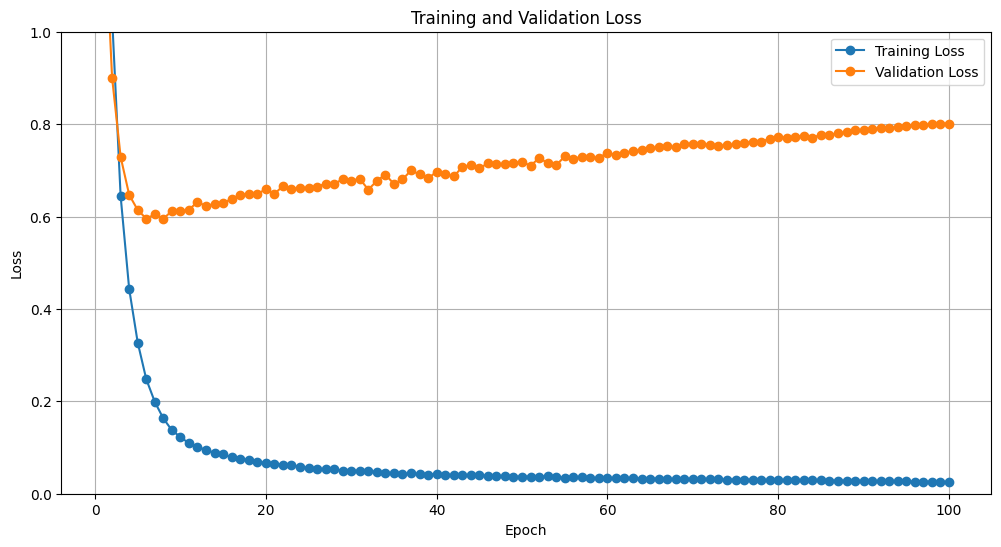

In [23]:
# 손실 값 시각화
import matplotlib.pyplot as plt

# 손실 값 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim([0, 1])
plt.grid(True)
plt.show()

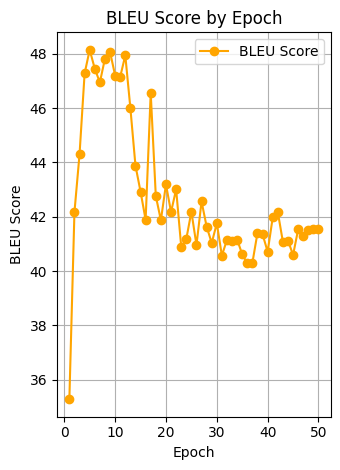

In [20]:
# BLEU 점수 시각화
plt.subplot(1, 2, 2)
plt.plot(range(1, len(bleu_scores) + 1), bleu_scores, label='BLEU Score', marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.title('BLEU Score by Epoch')
plt.legend()
plt.grid(True)

# 전체 시각화 출력
plt.tight_layout()
plt.show()

## 5. test

In [1]:
del model

NameError: name 'model' is not defined

In [22]:
# 학습이 끝난 후, 가장 낮은 Validation Loss를 가진 모델 로드
'''best_checkpoint_path = './checkpoints'

if best_checkpoint_path:
    print(f'Loading best model from {best_checkpoint_path}')
    checkpoint = torch.load(best_checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])'''

Loading best model from ./checkpoints


/tmp/ipykernel_11812/66188837.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_checkpoint_path)


IsADirectoryError: [Errno 21] Is a directory: './checkpoints'

In [23]:
# 체크포인트 로드
checkpoint_path = './checkpoints/checkpoint_epoch_9.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

/tmp/ipykernel_11812/2821339478.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [25]:
import torch
import sacrebleu
from tqdm import tqdm

# 모델을 GPU로 이동
model = model.to(device)

# 모델을 평가 모드로 설정
model.eval()

# 예측 및 참조 번역 수집
predictions = []
references = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        # 입력 데이터를 GPU로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 모델에 데이터 전달
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=256,  # 적절한 max_length 설정
            length_penalty=2.0,  # 번역 길이 조절
            num_beams=4,  # 빔 서치의 수
            early_stopping=True
        )

        # 예측 결과 디코딩
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # 실제 레이블 디코딩
        decoded_labels = []
        for label in labels:
            # 패딩 토큰 ID 제외
            label_ids = label[label != tokenizer.pad_token_id].tolist()
            if label_ids:
                try:
                    decoded_label = tokenizer.decode(label_ids, skip_special_tokens=True)
                except OverflowError:
                    decoded_label = "[UNK]"  # Unknown token으로 처리
                decoded_labels.append(decoded_label)
            else:
                decoded_labels.append('')  # 빈 문자열로 처리

        # 예측 결과와 참조 번역 수집
        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

# BLEU 점수 계산
bleu_score = sacrebleu.corpus_bleu(predictions, [references])
print(f'BLEU score: {bleu_score.score:.4f}')


Evaluating: 100%|██████████| 53/53 [00:15<00:00,  3.40it/s]

BLEU score: 33.0156


In [ ]:
# 기본
import torch

def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []
    for sentence in sentences:
        # 토큰화 및 텐서 변환
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)

        # 모델에 데이터 전달
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        for output in output_ids:
            translation = tokenizer.decode(output, skip_special_tokens=True)
            translations.append(translation)

    return translations

In [ ]:
# 테스트 문장
# test_sentences = ["날씨 덥다 화 난다.", "지금 바쁘다 미래 연락."]
test_sentences = ["날씨 덥다 화 난다", "목 마르다 물 원하다"]

translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['날씨가 더워서 화났다', '목 자주 마시고 싶어']


In [ ]:
# 앞 문장과 합성해서 뒷 문장 내용 추출

def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []

    for i, sentence in enumerate(sentences):
        if i > 0:
            # 이전 번역된 문장을 참조하지 않고 현재 문장만 입력으로 사용
            combined_sentence = sentences[i-1] + " " + sentence
        else:
            combined_sentence = sentence

        # 토큰화 및 텐서 변환
        inputs = tokenizer(combined_sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)

        # 모델에 데이터 전달
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        translation = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        translations.append(translation)

    return translations

In [ ]:
# 테스트 문장
test_sentences = ["날씨 덥다 화 난다", "목 마르다 물 원하다"]

# 번역 결과 생성
translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['날씨가 더워서 화났다', '날씨가 더워서 목이 마르고 싶다']


In [ ]:
# context vector 고려해 문장 생성.. -> 해결 미 완료
def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []
    context_vector = None

    for sentence in sentences:
        # 현재 문장만을 토큰화 및 텐서 변환
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동하고 Long 타입으로 변환
        input_ids = inputs['input_ids'].to(model.device).long()
        attention_mask = inputs['attention_mask'].to(model.device).long()

        # 문맥 벡터가 있는 경우 이를 입력에 반영
        if context_vector is not None:
            # 문맥 벡터를 추가할 때, 크기를 맞추기 위해 적절히 변환
            context_vector = context_vector.unsqueeze(1)  # [batch_size, 1, hidden_size]

            # 문맥 벡터를 다음 문장의 시작으로 사용 (단일 벡터로 시작 부분을 교체)
            input_ids = torch.cat([context_vector.squeeze(2).long(), input_ids[:, 1:]], dim=1)
            attention_mask = torch.cat([torch.ones_like(context_vector.squeeze(2)), attention_mask[:, 1:]], dim=1)

        # 모델에 데이터 전달
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        context_vector = outputs.encoder_last_hidden_state[:, -1, :]  # 인코더의 마지막 히든 상태를 문맥 벡터로 사용

        # 텍스트 생성
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        translation = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        translations.append(translation)

    return translations

In [ ]:
# 테스트 문장
test_sentences = ["날씨 덥다 화 난다", "목 마르다 물 원하다"]

# 번역 결과 생성
translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

RuntimeError: Tensors must have same number of dimensions: got 3 and 2